# BS879 Final Project- North American Rheumatoid Arthritis Consortium
**By: Johnathan Zhang**

## Question 0: Basic Data Exploration
Before starting the project, here are some commands to perform preliminary/very basic data exploration on the NARAC data.

In [1]:
%%bash
echo 'Here are the given data files:' && echo
tree data

Here are the given data files:

data
├── EAS.1000G.AF.
├── EUR.1000G.AF.
├── RA_GWASmeta_Asian_v2.txt.gz
├── RA_GWASmeta_European_v2.txt
├── RA_GWASmeta_TransEthnic_v2.txt.gz
├── narac.cov
├── narac_hg19.bed
├── narac_hg19.bim
└── narac_hg19.fam

0 directories, 9 files


In [2]:
%%bash
echo 'Number of variants included in study'
wc -l data/narac_hg19.bim
echo && echo 'Number of individuals included in study'
wc -l data/narac_hg19.fam

Number of variants included in study
544276 data/narac_hg19.bim

Number of individuals included in study
2062 data/narac_hg19.fam


In the raw data for this study, there are 500K+ variants and 2062 individuals.

---

## Question 1: QC/QA and PCA 

> In your write up, state and justify the analyses you did and in what order, and how many individuals and SNPs you removed and retained at each step. Provide your recommendations on which PCs to include in case- control GWAS analyses, and explain your choice

### 1A Perform genetic data cleaning of the NARAC GWAS data. 
The first step in analyzing our GWAS data is to perform quality control and quality filtering. Plink 1.9 offers many ways to do so, and I perform these in the following order:
1) Basic quality metrics like minimum minor allele frequency, a maximum missing genotyping rate, exclude markers that fail a Hardy Weinberg Equillibrium test, and remove individuals with high amounts of missing data. To maximize the number individuals, I filter by individuals with high amounts of missing data last. I filter for maf < 0.01. which is on the lower side but not too low as GWAS is not designed to test for very rare variant-associated diseases. I test for a standard maximum missing genotype rate of 0.05, but this is a relatively recent study and high quality chip (compared to the TGEN alzheimer's dataset) so most variants should pass this filter. I filter by a standard hwe of 1e-6 threshold as well. Lastly, I set maximum missing data per individual to a more strict 0.02 because of the modern chip and high quality data. From my inspection of the meta-analysis data in the Okada et. al. study (used for #3), these filters are standard and commonly used for modern chips and GWAS experiments.
2) Test for differential missingness for variants: This section tests for potential patterns for missingness in each variant across cases and controls. This will help control for spurious associations related to the missingness of data rather than the variant itself. Variants that have associations with p values less than 0.0001 are removed to remove only confidently identified associations.
3) Pruning was performed using `--indep-pairwise 10000kb 1 0.2`, meaning for each pair of variants, if they are within a window of 10000kb and have a pairwise correlation (r squared) greater than 0.2, then variants are pruned (removed). The correlation value of 0.2 is strict, but there are a large amount of variants before and after pruning still.
4) Part 4 tests for a relationship between heterozygosity and missingness in variants. I first generate heterozygosity scores using plink's `--het` flag and then generate F statistics (a measure of observed vs expected heterozygosity). I generate a plot of number of missing genotypes in an individual x F statistics. I perform this step on only chromsomes 1-22 (no sex chromsomes) as heterozygosity and missingness patterns are different for sex chromosomes.
5) Part 5 tests performs a sex check using plink's `--check-sex`, checking to see if the reported sex of individuals matches expected sex based on X chromosome inbreeding coefficients. I use plink's recommended/default F values to discern predicted males and females. 
6) Part 6 calculates identity by descent for all pairs of inviduals in the study using plink's `--genome` and reports a pi_hat value. Individuals that are very closely related (third degree relatives) should be removed, and I used a pi_hat value of 0.125. 


### 1A Part 1: Basis Filtering using plink arguments (maf, geno, etc.)
First we take advantage of a number of plink arguments to filter out variants or individuals by a number of different metrics.

In [3]:
%%bash
## First filter the bed by maf, genotype rate, and hwe p-value
plink \
    --bfile data/narac_hg19 \
    --maf 0.01 \
    --geno 0.05 \
    --hwe 1e-6 \
    --make-bed \
    --out q1.1_narac_SNPFilter

## Then filter the output bed of above by missing-individual-ness
plink \
    --bfile q1.1_narac_SNPFilter \
    --mind 0.02 \
    --make-bed \
    --out q1.2_narac_indFilter

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.1_narac_SNPFilter.log.
Options in effect:
  --bfile data/narac_hg19
  --geno 0.05
  --hwe 1e-6
  --maf 0.01
  --make-bed
  --out q1.1_narac_SNPFilter

191515 MB RAM detected; reserving 95757 MB for main workspace.
544276 variants loaded from .bim file.
2062 people (569 males, 1493 females) loaded from .fam.
2062 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2062 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


many commands treat these as missing.
treat these as missing.


Total genotyping rate is 0.99269.
18402 variants removed due to missing genotype data (--geno).


chromosome.  You may want to use a less stringent --hwe p-value threshold for X
chromosome variants.


--hwe: 663 variants removed due to Hardy-Weinberg exact test.
22907 variants removed due to minor allele threshold(s)
(--maf/--max-maf/--mac/--max-mac).
502304 variants and 2062 people pass filters and QC.
Among remaining phenotypes, 868 are cases and 1194 are controls.
--make-bed to q1.1_narac_SNPFilter.bed + q1.1_narac_SNPFilter.bim +
q1.1_narac_SNPFilter.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.2_narac_indFilter.log.
Options in effect:
  --bfile q1.1_narac_SNPFilter
  --make-bed
  --mind 0.02
  --out q1.2_narac_indFilter

191515 MB RAM detected; reserving 95757 MB for main workspace.
502304 variants loaded from .bim file.
2062 people (569 males, 1493 females) load

many commands treat these as missing.
treat these as missing.


Total genotyping rate in remaining samples is 0.996095.
502304 variants and 2020 people pass filters and QC.
Among remaining phenotypes, 851 are cases and 1169 are controls.
--make-bed to q1.2_narac_indFilter.bed + q1.2_narac_indFilter.bim +
q1.2_narac_indFilter.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.


> **Note the warning**: `Warning: 8824 het. haploid genotypes present (see q1.2_narac_indFilter.hh );
many commands treat these as missing.`. After sifting through some documentation [online](https://www.cog-genomics.org/plink/1.9/errors) and having documented solutions fail (using `--split-x` did not fix), I decided to remove the variants listed in the .hh file. To do this, I extract the unique SNP's in the .hh file using `awk` and provide that into a third plink command to make a new bed.

In [4]:
%%bash
## extract list of SNP's that are causing problems
awk '{print $3}' q1.2_narac_indFilter.hh | sort | uniq -c > q1.2_hh_remove.txt

Now I provide this file as part of an `--exclude` flag to remove them, and this output will be used for analyses downstream by making a new bed file (and associated fam/bim).

In [5]:
%%bash
## use the list generated above to remove those problematic SNP's
plink \
    --bfile q1.2_narac_indFilter \
    --exclude q1.2_hh_remove.txt \
    --make-bed \
    --out q1.3_narac_no_hh

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.3_narac_no_hh.log.
Options in effect:
  --bfile q1.2_narac_indFilter
  --exclude q1.2_hh_remove.txt
  --make-bed
  --out q1.3_narac_no_hh

191515 MB RAM detected; reserving 95757 MB for main workspace.
502304 variants loaded from .bim file.
2020 people (559 males, 1461 females) loaded from .fam.
2020 phenotype values loaded from .fam.
--exclude: 495588 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2020 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


treat these as missing.


Total genotyping rate is 0.996099.
495588 variants and 2020 people pass filters and QC.
Among remaining phenotypes, 851 are cases and 1169 are controls.
--make-bed to q1.3_narac_no_hh.bed + q1.3_narac_no_hh.bim +
q1.3_narac_no_hh.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.


#### 1A part 1 notes *(basic filtering using plink)*
The genotype rate for this dataset is very high, so I choose to be more strict with certain filters. Using `-geno 0.05` flag removed 18402 variants. Using the `--hwe 1e-6` flag removed 663 variants. Using the `--maf 0.01` removed 22907 variants. These three filters were performed before the missing individual filter to maximize the number of individuals to be retained. Using the `--mind 0.02` flag removed 42 individuals. 

In the end, there were **495588 variants and 2020 people** that passed this round of QC.

### 1A Part 2: Test for differential missingness for variants

This part tests to see if missing variants exhibit any patterns related to case status. If missingness by case status is non-random, this could result in false associations. I test for highly significant variants using p-value 0.00001.

In [6]:
%%bash
#    --adjust gc \
## Test for differential missingness by case status
plink --bfile q1.3_narac_no_hh \
    --test-missing \
    --out q1.4_narac_diff

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.4_narac_diff.log.
Options in effect:
  --bfile q1.3_narac_no_hh
  --out q1.4_narac_diff
  --test-missing

191515 MB RAM detected; reserving 95757 MB for main workspace.
495588 variants loaded from .bim file.
2020 people (559 males, 1461 females) loaded from .fam.
2020 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2020 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


treat these as missing.


Total genotyping rate is 0.996099.
495588 variants and 2020 people pass filters and QC.
Among remaining phenotypes, 851 are cases and 1169 are controls.
Writing --test-missing report to q1.4_narac_diff.missing ... done.


In [7]:
%%bash

## how many variants have significant differential missingness by case status (pval < 0.0001)
awk '$5<0.00001{print $0}' q1.4_narac_diff.missing > q1.4_narac_diff.sig_missing

## generate list of SNP's that are significant 
awk '{print $2}' q1.4_narac_diff.sig_missing > q1.4_narac_sig_missing.exclude
wc -l q1.4_narac_sig_missing.exclude

3907 q1.4_narac_sig_missing.exclude


Here are some of the SNP's in the file to exclude

In [8]:
%%bash
sort -gk 5 q1.4_narac_diff.sig_missing | head
echo
head q1.4_narac_sig_missing.exclude

  12   rs1316952      0.09871     0.001711    3.278e-30
   6   rs2233434       0.1069     0.005133    1.856e-28
  19    rs313784       0.1046     0.005133    1.044e-27
   4    rs177798      0.09871     0.004277    8.367e-27
   9    rs496503      0.09166     0.002566    1.175e-26
  14  rs17091448       0.1046     0.006843    6.431e-26
  16   rs2318445      0.09518     0.004277    1.117e-25
  14   rs7152944      0.09988     0.005988     2.59e-25
  22    rs733278      0.09048     0.003422    3.484e-25
  12    rs876734       0.1011     0.006843    7.942e-25

rs6675798
rs2803291
rs260512
rs2494428
rs2297829
rs1333190
rs12745860
rs10915373
rs242056
rs242044


In [9]:
%%bash

plink --bfile q1.3_narac_no_hh \
    --exclude q1.4_narac_sig_missing.exclude \
    --make-bed \
    --out q1.4_narac_test_missing

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.4_narac_test_missing.log.
Options in effect:
  --bfile q1.3_narac_no_hh
  --exclude q1.4_narac_sig_missing.exclude
  --make-bed
  --out q1.4_narac_test_missing

191515 MB RAM detected; reserving 95757 MB for main workspace.
495588 variants loaded from .bim file.
2020 people (559 males, 1461 females) loaded from .fam.
2020 phenotype values loaded from .fam.
--exclude: 491681 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2020 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


treat these as missing.


Total genotyping rate is 0.996295.
491681 variants and 2020 people pass filters and QC.
Among remaining phenotypes, 851 are cases and 1169 are controls.
--make-bed to q1.4_narac_test_missing.bed + q1.4_narac_test_missing.bim +
q1.4_narac_test_missing.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.


#### 1A Part 2 Notes *(test for differnetial missingness by case status)*

Testing for variants with differential missingness by case status identified 3908 significant variants (pval < 0.0001). These variants may cause spurious associations and as a result are removed from downstream analyses. The most differntially missing SNP has a difference of ~0.09. 

After removing these SNP's there are **491681 variants and 2020 people pass filters and QC**.

### 1A Part 3: Filtering by pruning SNP's
Next, I  remove a significant amount of variants in this study by pruning using `--indep-pairwise`. Here I give a large window to check for linked SNP's of 10000kb, and specify a greedy maximum r-squared value of 0.2 to remove SNP's (or really one SNP out of a pair) that show signs of pairwise correlation with another SNP in that window. This first plink command generates files of variants that have been pruned versus kept. The second plink command uses the file of pruned variants and makes a new bed that excludes these pruned variants.

In [10]:
%%bash
## generate list of SNPs that were pruned 
plink --bfile q1.4_narac_test_missing \
    --indep-pairwise 10000kb 1 0.2 \
    --out q1.5_narac

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.5_narac.log.
Options in effect:
  --bfile q1.4_narac_test_missing
  --indep-pairwise 10000kb 1 0.2
  --out q1.5_narac

191515 MB RAM detected; reserving 95757 MB for main workspace.
491681 variants loaded from .bim file.
2020 people (559 males, 1461 females) loaded from .fam.
2020 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2020 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


treat these as missing.


Total genotyping rate is 0.996295.
491681 variants and 2020 people pass filters and QC.
Among remaining phenotypes, 851 are cases and 1169 are controls.
Pruned 28744 variants from chromosome 1, leaving 8382.
Pruned 32388 variants from chromosome 2, leaving 7998.
Pruned 26765 variants from chromosome 3, leaving 6873.
Pruned 23519 variants from chromosome 4, leaving 6292.
Pruned 24510 variants from chromosome 5, leaving 6419.
Pruned 26113 variants from chromosome 6, leaving 6408.
Pruned 21185 variants from chromosome 7, leaving 5653.
Pruned 23115 variants from chromosome 8, leaving 5303.
Pruned 19124 variants from chromosome 9, leaving 4919.
Pruned 20417 variants from chromosome 10, leaving 5418.
Pruned 19192 variants from chromosome 11, leaving 4978.
Pruned 18959 variants from chromosome 12, leaving 5285.
Pruned 14578 variants from chromosome 13, leaving 3929.
Pruned 12888 variants from chromosome 14, leaving 3612.
Pruned 11502 variants from chromosome 15, leaving 3350.
Pruned 11368 var

In [11]:
%%bash
## use list of pruned SNP's to exclude and generate new bed
plink --bfile q1.4_narac_test_missing \
    --exclude q1.5_narac.prune.out \
    --make-bed \
    --out q1.5_narac_pruned

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.5_narac_pruned.log.
Options in effect:
  --bfile q1.4_narac_test_missing
  --exclude q1.5_narac.prune.out
  --make-bed
  --out q1.5_narac_pruned

191515 MB RAM detected; reserving 95757 MB for main workspace.
491681 variants loaded from .bim file.
2020 people (559 males, 1461 females) loaded from .fam.
2020 phenotype values loaded from .fam.
--exclude: 106358 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2020 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


treat these as missing.


Total genotyping rate is 0.99649.
106358 variants and 2020 people pass filters and QC.
Among remaining phenotypes, 851 are cases and 1169 are controls.
--make-bed to q1.5_narac_pruned.bed + q1.5_narac_pruned.bim +
q1.5_narac_pruned.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.


#### 1A Part 3 Notes *(pruning)*
Roughly 380K of the roughly 490K variants are removed through the process of pruning. 

After pruning, we are left with **106358 variants and 2020 people passing pruning**

### 1A Part 4 Heterozygosity, Inbreeding and Missingness Coeffecient
I calculate the inbreeding coefficient and heterozygosity statistics for all individuals using the pruned genotypes using plink and an R script provided previously in this class. This tests to see if F statistics (a measure of observed vs expected heterozygosity) is related to missingness of variants in individuals. Again, we restrict this step to only autosomal chromsomes and not sex chromosomes due to differences in underlying missingness and heterozygosity patterns.

In [12]:
%%bash
## Here we calculate heterozygosity statistics
plink --bfile q1.5_narac_pruned \
    --chr 1-22 \
    --het \
    --out q1.6_narac_het

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.6_narac_het.log.
Options in effect:
  --bfile q1.5_narac_pruned
  --chr 1-22
  --het
  --out q1.6_narac_het

191515 MB RAM detected; reserving 95757 MB for main workspace.
104552 out of 106358 variants loaded from .bim file.
2020 people (559 males, 1461 females) loaded from .fam.
2020 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2020 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996482.
104552 variants and 2020 people pass filters and QC.
Among remaining phenotypes, 851 are cases and 1169 are controls.
--het: 1

In [13]:
%%bash
# Here is the Rscript used to generate a plot of heterozygosity x missingness from the heterozygosity file generated
cat Fstat.R

het<-read.table("q1.6_narac_het.het",header=T,as.is=T)

summary(het$F)
mean(het$F)
sd(het$F)

jpeg("hetplot.jpeg")
plot(het$N.NM.,het$F,xlab="N Non-Missing",ylab="F")

dev.off()

summary(lm(het$N.NM.~het$F))



In [14]:
%%bash
# Run the Rscript
Rscript Fstat.R

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.031690 -0.000919  0.004303  0.004422  0.009580  0.079830 
[1] 0.004422113
[1] 0.009100552
null device 
          1 

Call:
lm(formula = het$N.NM. ~ het$F)

Residuals:
    Min      1Q  Median      3Q     Max 
-1855.0  -101.3    67.4   181.5  1160.6 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 104235.52       7.08 14722.26   <2e-16 ***
het$F       -11613.61     699.89   -16.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 286.2 on 2018 degrees of freedom
Multiple R-squared:  0.1201,	Adjusted R-squared:  0.1196 
F-statistic: 275.3 on 1 and 2018 DF,  p-value: < 2.2e-16



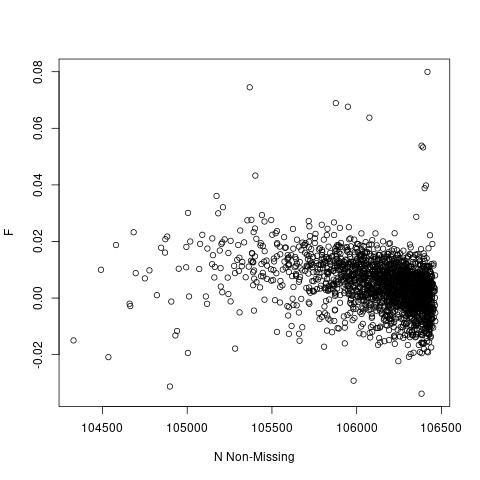

#### 1A Part 4 Notes *(Inbreeding, Heterozygosity, Missingness)*

The range of F values (which represents expected vs observed heterozygosity) is (-0.031690, 0.079830), with a mean of 0.004422 and median of 0.004303. The means and median around 0 show that expected versus observed closely line up. 

However, the linear model shows that heterozygosity is very strongly associated with missingness:
`Estimate: -11613.61    Std. Error: 699.89  t value: -16.59    Pr(>|t|): <2e-16 ***`

The negative estimate suggests that as the number of non-missing genotypes increases, observed heterozygosity increases. Missing genotypes are more likely to be homozygous.

### A1 Part 5 Checking for observed and expected sex

This step checks to see if the reported sex matches the observed sex (using heterozygosity coefficients (F statistic).

In [15]:
%%bash
## Use plink's check sex flag to generate a report of problematic individuals
plink --bfile q1.5_narac_pruned \
    --check-sex \
    --out q1.7_narac

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.7_narac.log.
Options in effect:
  --bfile q1.5_narac_pruned
  --check-sex
  --out q1.7_narac

191515 MB RAM detected; reserving 95757 MB for main workspace.
106358 variants loaded from .bim file.
2020 people (559 males, 1461 females) loaded from .fam.
2020 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2020 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


treat these as missing.


Total genotyping rate is 0.99649.
106358 variants and 2020 people pass filters and QC.
Among remaining phenotypes, 851 are cases and 1169 are controls.
--check-sex: 1803 Xchr and 0 Ychr variant(s) scanned, 4 problems detected.
Report written to q1.7_narac.sexcheck .


In [16]:
%%bash
## Select problem individuals and get their FID and IID
awk '$5!="OK" && NR>1 {print $1,$2}' q1.7_narac.sexcheck > q1.7_narac.sexcheck.remove
cat q1.7_narac.sexcheck.remove

1050200 1050200
D0001118 D0001118
D0021693 D0021693
D0004418 D0004418


In [17]:
%%bash
plink --bfile q1.5_narac_pruned \
    --remove q1.7_narac.sexcheck.remove \
    --make-bed \
    --out q1.7_narac_postSC

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.7_narac_postSC.log.
Options in effect:
  --bfile q1.5_narac_pruned
  --make-bed
  --out q1.7_narac_postSC
  --remove q1.7_narac.sexcheck.remove

191515 MB RAM detected; reserving 95757 MB for main workspace.
106358 variants loaded from .bim file.
2020 people (559 males, 1461 females) loaded from .fam.
2020 phenotype values loaded from .fam.
--remove: 2016 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2016 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


treat these as missing.


Total genotyping rate in remaining samples is 0.996489.
106358 variants and 2016 people pass filters and QC.
Among remaining phenotypes, 850 are cases and 1166 are controls.
--make-bed to q1.7_narac_postSC.bed + q1.7_narac_postSC.bim +
q1.7_narac_postSC.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.


#### 1A Part 5 Notes *(Sex check)*

When using F < 0.2 for females and F > 0.8, there were 4 individuals that were reported as inconsistent. These individuals were removed.

After this step, there were **108363 variants and 2016 people passing filters and QC**.

### 1A Part 6 Testing individuals for genetic relatedness
Next is to filter out individuals that are closely related to each other (2nd degree relatives or closer) by computing IBD estimates. I exclude sex chromosomes for this step as well because patterns of inheritance are different than the autosomal chromosomes. 

In [18]:
%%bash
## generate a .genome file where we can test for IBD
plink --bfile q1.7_narac_postSC \
    --chr 1-22 \
    --genome \
    --out q1.8_narac_ibd

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.8_narac_ibd.log.
Options in effect:
  --bfile q1.7_narac_postSC
  --chr 1-22
  --genome
  --out q1.8_narac_ibd

191515 MB RAM detected; reserving 95757 MB for main workspace.
104552 out of 106358 variants loaded from .bim file.
2016 people (559 males, 1457 females) loaded from .fam.
2016 phenotype values loaded from .fam.
Using up to 31 threads (change this with --threads).
Before main variant filters, 2016 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996481.
104552 variants and 2016 people pass filters and QC.
Among remaining phenotypes, 850 are cases and 1166 are controls.
IBD calc

In [19]:
%%bash
# search for individualas that are closely related (pi_hat > 0.125)
awk '$10 > 0.125 {print $0}' q1.8_narac_ibd.genome > q1.8_narac_ibd_gt0.125.txt

# how many pairs of individuals are highly related?
head q1.8_narac_ibd_gt0.125.txt

echo && echo 'Looks like there are no individuals that are closely related'
wc -l q1.8_narac_ibd_gt0.125.txt

      FID1      IID1      FID2      IID2 RT    EZ      Z0      Z1      Z2  PI_HAT PHE       DST     PPC   RATIO

Looks like there are no individuals that are closely related
1 q1.8_narac_ibd_gt0.125.txt


#### 1A Part 6 Notes *(Testing for relatedness in individuals)*
After creating a `.genome` file with plink to identify relatedness between individuals, I filter this file for pi_hat values greater than 0.125, in other words, select for pairs of individuals that are at most distantly related 3rd degree cousins. However, filtering for pi_hat > 0.125 yielded no individuals pairs, meaning that all individuals in this study are not closely related to each other by this threshold. 

If there were pairs of individuals that were closely related, I would have extracted the two columns representing individual pairs and generated a single list of unique individuals. I would remove one individual from each pair of individuals from the list of unique individuals, and then proceed to remove the remaining list from the plink dataset. 

**No variants or individuals were filtered out in this step**

### 1A Summary
**After performing genetic cleaning, we are left with 108363 variants and 2016 people in this study.**

Originally, there were 544276 variants and 2062 individuals

---

### 1B Then, perform PCA on the data to identify study outliers, and create a set of PCs that can be used in association analyses. 

I perform PCA to analyze underlying population structure (or other covariates that may contribute to variation in our results) and assess if there are still any individuals that are genetically very different than everyone else (genetic outliers). Principal component analysis is a dimensionality reduction algorithm that allows us to extract multi-dimension variables, the principle componenets, to capture underlying patterns of variance. 

### 1B PCA Step 1
We will use the cleaned dataset from part 1A to run PCA using the eigensoft `smartpca` command. The PCA will allow us to extract any underlying population structure within the study. The first step will be to create a config file that points to the bed files and includes other parameters. We specify to report the top 10 principle components. 

In [20]:
%%bash
## par file for smartpca
cat q1_pca.par

genotypename: q1.7_narac_postSC.bed
snpname: q1.7_narac_postSC.bim
indivname: q1.7_narac_postSC.fam
evecoutname: q1.9_pca.evec
evaloutname: q1.9_pca.eval
altnormstyle: NO
numoutevec: 10
numoutlieriter: 0


In [21]:
%%bash
# Run the PCA
smartpca -p q1_pca.par > q1_pca.out

In [22]:
%%bash
# Print out just the useful information from the long ass log from smartpca
sed -n '2069,2112p;2113q' q1_pca.out


eigenvector 1:means
             Control     -0.004
                Case      0.006
## Anova statistics for population differences along each eigenvector:
                                              p-value
             eigenvector_1_Control_Case_   9.99201e-16 +++
eigenvector 2:means
                Case     -0.006
             Control      0.004
             eigenvector_2_Control_Case_   3.33067e-16 +++
eigenvector 3:means
             Control     -0.000
                Case      0.001
             eigenvector_3_Control_Case_      0.248414 
eigenvector 4:means
             Control     -0.008
                Case      0.011
             eigenvector_4_Control_Case_             0 +++
eigenvector 5:means
             Control     -0.000
                Case      0.001
             eigenvector_5_Control_Case_      0.260672 
eigenvector 6:means
                Case     -0.001
             Control      0.000
             eigenvector_6_Control_Case_      0.304449 
eigenvector 7:means
     

According to this report, there are three principle components (eigenvectors) that are statistically significant in explaining variation in our data. These are PC1, PC2, and PC4.

### 1B Part 2 Plotting the PCA
Now we can plot the results using the provided R script from class. When examining the first 10 principal components, we observe three principal components being highly significant between cases and controls. These are PC1, PC2, and PC4. We can create 3 plots that capture these principal components being plotted against each other.

In [23]:
%%bash
# Here is the R script
cat plotPCs.R

##Rscript --vanilla plotPCs.R filename x  y NPC 
##Assumes smartpca file "filename" with Number of PCs+2 columns 
## x and y are PC (numbers)
## NPC is the number of PCs in the file 
##

args<-commandArgs(trailingOnly=TRUE)
print(args)
infile<-args[1]
x<-as.numeric(args[2])
y<-as.numeric(args[3])
N<-as.numeric(args[4])
#infile<-"test.evec"
#N<-10
#x<-1
#y<-2
yy<-read.table(infile,header=F,skip=1,col.names=c("ID",paste("PC",1:N,sep=""),"CASE"),as.is=T)

bitmap(paste(c(infile,".PC.",x,".",y,".jpeg"),collapse=""))
plot(yy[,x+1],yy[,y+1],col=as.numeric(as.factor(yy[,N+2])),xlab=paste("PC",x,sep=""),ylab=paste("PC",y,sep=""))
legend("bottom",legend=unique(as.factor(yy[,N+2])),col=as.numeric(unique(as.factor(yy[,N+2]))),horiz=TRUE,pch=1,bty="n")
dev.off()



In [24]:
%%bash
# Here we run the Rscript three times, 
Rscript --vanilla plotPCs.R q1.9_pca.evec 1 2 10
Rscript --vanilla plotPCs.R q1.9_pca.evec 1 4 10
Rscript --vanilla plotPCs.R q1.9_pca.evec 2 4 10

[1] "q1.9_pca.evec" "1"             "2"             "10"           
null device 
          1 
[1] "q1.9_pca.evec" "1"             "4"             "10"           
null device 
          1 
[1] "q1.9_pca.evec" "2"             "4"             "10"           
null device 
          1 


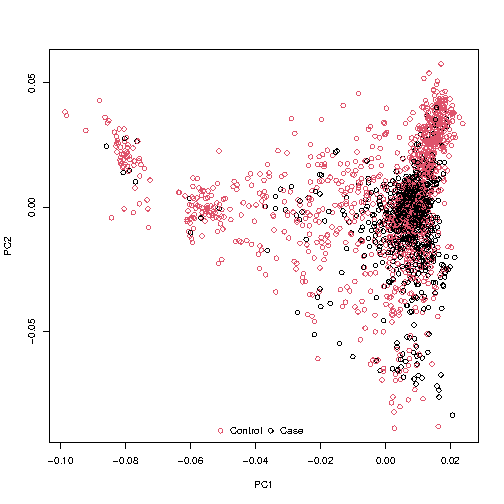

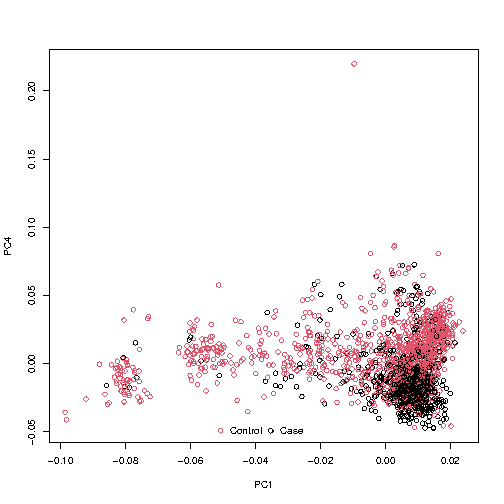

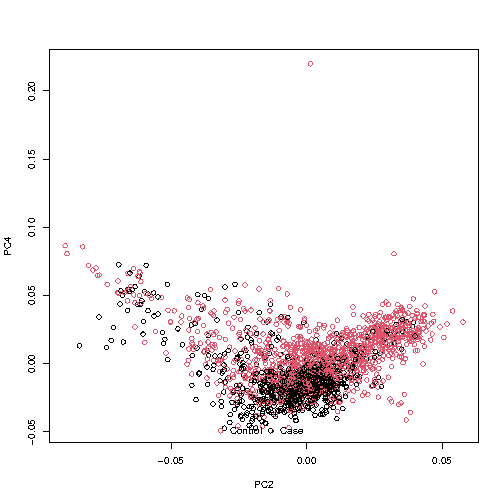

Across all three PC's we observe no remaining structure (no dinstinct clumps between cases and controls). However, in the PC2 vs PC4 plot and PC1 vs PC4 plot, there is clearly a suspect individual in the PC4 axis that appears to be genetically very different than the rest of the individuals. We should remove this individual by identifying their ID in the `.evec` file and removing them from the plink bed. 

In [25]:
%%bash
awk '$5 > 0.2 {print $0}' q1.9_pca.evec

           #eigvals:     5.424     2.069     1.913     1.637     1.400     1.374     1.369     1.367     1.366     1.363 


As we can see this individual has a very high value for PC4, 0.2198. Let's make a new bed without this individual, and also rerun PCA without this individual. 

In [26]:
%%bash
plink --bfile q1.7_narac_postSC \
    --remove q1.9_pc4_outlier.txt \
    --make-bed \
    --out q1.10_narac_pcaOutlier

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q1.10_narac_pcaOutlier.log.
Options in effect:
  --bfile q1.7_narac_postSC
  --make-bed
  --out q1.10_narac_pcaOutlier
  --remove q1.9_pc4_outlier.txt

191515 MB RAM detected; reserving 95757 MB for main workspace.
106358 variants loaded from .bim file.
2016 people (559 males, 1457 females) loaded from .fam.
2016 phenotype values loaded from .fam.
--remove: 2015 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2015 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


treat these as missing.


Total genotyping rate in remaining samples is 0.996494.
106358 variants and 2015 people pass filters and QC.
Among remaining phenotypes, 850 are cases and 1165 are controls.
--make-bed to q1.10_narac_pcaOutlier.bed + q1.10_narac_pcaOutlier.bim +
q1.10_narac_pcaOutlier.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.


In [27]:
%%bash
smartpca -p q1.10_pca.par > q1.10_pca.out

In [28]:
%%bash
# Print out just the useful information from the log from PCA
sed -n '2069,2112p;2113q' q1.10_pca.out

eigenvector 1:means
             Control     -0.004
                Case      0.006
## Anova statistics for population differences along each eigenvector:
                                              p-value
             eigenvector_1_Control_Case_             0 +++
eigenvector 2:means
                Case     -0.006
             Control      0.004
             eigenvector_2_Control_Case_             0 +++
eigenvector 3:means
             Control     -0.000
                Case      0.001
             eigenvector_3_Control_Case_      0.258811 
eigenvector 4:means
             Control     -0.008
                Case      0.011
             eigenvector_4_Control_Case_   6.66134e-16 +++
eigenvector 5:means
                Case     -0.000
             Control      0.000
             eigenvector_5_Control_Case_      0.393243 
eigenvector 6:means
                Case     -0.000
             Control      0.000
             eigenvector_6_Control_Case_       0.40961 
eigenvector 7:means
      

We still see the same PC's being significant, and below are the updated plots. While we observe a new PC being potentially significant, PC10, it is not as significant as the original PCs 1, 2, and 4, and will not be included.

In [29]:
%%bash
Rscript --vanilla plotPCs.R q1.10_pca.evec 1 2 10
Rscript --vanilla plotPCs.R q1.10_pca.evec 1 4 10
Rscript --vanilla plotPCs.R q1.10_pca.evec 2 4 10

[1] "q1.10_pca.evec" "1"              "2"              "10"            
null device 
          1 
[1] "q1.10_pca.evec" "1"              "4"              "10"            
null device 
          1 
[1] "q1.10_pca.evec" "2"              "4"              "10"            
null device 
          1 


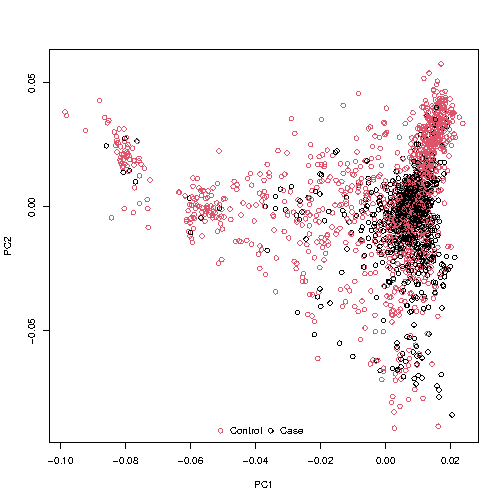

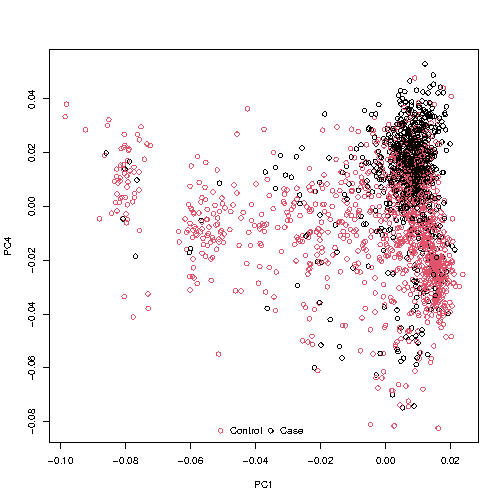

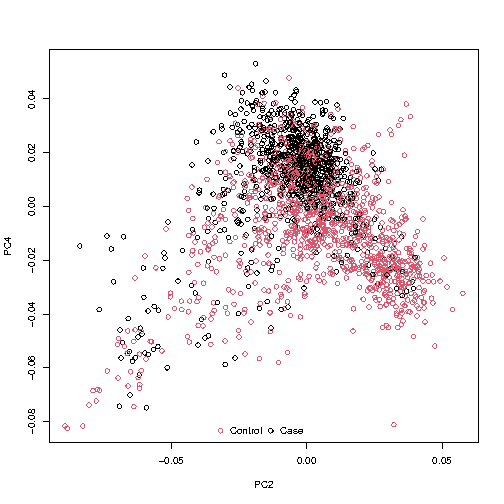

With the problematic individual removed, I observe no more outliers in the 3 plots, and it appears we have succesfully captured underlying population stratifications with these three principle components. Moving forard, I restructure the `evec` file so it can be used downstream for plink analyses and control for population structure or other covariates.

In [30]:
%%bash
## Copy code from homework assignment to make this file
awk 'NR>1 {print $0}' q1.10_pca.evec > temp1
sed 's/:/\t/' temp1>temp2
awk 'NR==1{print "FID IID PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10"}; 
NR>=1 {print $1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12}' temp2> q1.10_narac_PCs.txt
head q1.10_narac_PCs.txt

FID IID PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10
D0024949 D0024949 0.0064 -0.0176 -0.0056 -0.0121 -0.0065 0.0114 0.0194 -0.0559 -0.0073 -0.0123
D0024302 D0024302 0.0173 0.0579 -0.0152 -0.0313 -0.0069 -0.0012 0.0326 0.0142 -0.0036 0.0082
D0022042 D0022042 0.0118 0.0217 -0.0094 -0.0129 -0.0104 -0.0138 -0.0028 0.0099 0.0255 -0.0040
D0021275 D0021275 0.0144 0.0277 -0.0022 -0.0221 -0.0246 -0.0022 0.0088 -0.0123 0.0131 0.0135
D0021163 D0021163 0.0032 -0.0115 0.0196 0.0128 0.0426 0.0235 0.0070 -0.0127 0.0065 -0.0129
D0020795 D0020795 0.0206 0.0386 0.0014 -0.0245 -0.0136 -0.0054 -0.0008 -0.0295 0.0004 -0.0182
D0020691 D0020691 0.0107 0.0215 -0.0001 -0.0147 -0.0065 -0.0095 -0.0048 -0.0031 -0.0302 0.0204
D0019121 D0019121 0.0166 0.0069 -0.0051 -0.0071 0.0071 -0.0422 -0.0125 0.0167 -0.0139 0.0491
D0018942 D0018942 0.0165 0.0287 -0.0079 -0.0333 -0.0119 -0.0142 -0.0046 0.0045 -0.0134 0.0006


## Question 2 GWAS

It is well known that the HLA region on chromosome 6p21 plays an important role in RA. It is also
well known that females are affected by RA much more frequently than males. Your goals are to
determine if there are additional genomic regions (in addition to the HLA region on chromosome 6)
that are associated with RA in females in this sample, and to determine whether any of the regions
are sex-specific. For all analyses, be sure to state and justify the significance criteria you use.

### 2A GWAS by sex using Plink2.0
Perform two genome-wide association analyses for rheumatoid arthritis: one using only female subjects, and one using only male subjects. Explain how you chose covariates, and how you accounted for population structure (or, if you chose not to account for population structure, justify your decision). Present a written summary of your results with appropriate plots and tables that describe your findings.

The first step is to split the cleaned dataset (q1.10) into males and females. Do this by filtering the fam file for the 5th column (gender) to create lists of males and females and then using plink to make new bed files for each subset.

To run the GWAS analysis, we will use plink 2.0 because it offers the ability to conveniently format the output correctly for the meta-analysis in the next step. I do run GWAS analyses with both plink 1.9 and GMMAT and compared the results, but for the sake of this report I moved that section to the very bottom as a "supplementary" section. The results for all three GWAS results were highly similar and I move forward with using plink 2.0

#### 2A Step 1: separate into female and male subset
The first step is to separate the fam file into women versus men based on the 5th column (sex). Then we feed these files into plink to remove the individuals by sex. 

In [31]:
%%bash
# Create list of just females or males for plink downstream
awk '$5 == 1 {print $1,$2}' q1.10_narac_pcaOutlier.fam > q2_narac_male_list.txt
awk '$5 == 2 {print $1,$2}' q1.10_narac_pcaOutlier.fam > q2_narac_female_list.txt

wc -l q2_narac_male_list.txt
wc -l q2_narac_female_list.txt

559 q2_narac_male_list.txt
1456 q2_narac_female_list.txt


In [32]:
%%bash
# Use these files in plink to separate dataset by sex
plink --bfile q1.10_narac_pcaOutlier \
    --remove q2_narac_male_list.txt \
    --make-bed \
    --out q2.1_narac_cleaned_females
    
plink --bfile q1.10_narac_pcaOutlier \
    --remove q2_narac_female_list.txt \
    --make-bed \
    --out q2.1_narac_cleaned_males

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q2.1_narac_cleaned_females.log.
Options in effect:
  --bfile q1.10_narac_pcaOutlier
  --make-bed
  --out q2.1_narac_cleaned_females
  --remove q2_narac_male_list.txt

191515 MB RAM detected; reserving 95757 MB for main workspace.
106358 variants loaded from .bim file.
2015 people (559 males, 1456 females) loaded from .fam.
2015 phenotype values loaded from .fam.
--remove: 1456 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1456 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


treat these as missing.


Total genotyping rate in remaining samples is 0.996399.
106358 variants and 1456 people pass filters and QC.
Among remaining phenotypes, 626 are cases and 830 are controls.
--make-bed to q2.1_narac_cleaned_females.bed + q2.1_narac_cleaned_females.bim +
q2.1_narac_cleaned_females.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q2.1_narac_cleaned_males.log.
Options in effect:
  --bfile q1.10_narac_pcaOutlier
  --make-bed
  --out q2.1_narac_cleaned_males
  --remove q2_narac_female_list.txt

191515 MB RAM detected; reserving 95757 MB for main workspace.
106358 variants loaded from .bim file.
2015 people (559 males, 1456 females) loaded from .fam.
2015 phenotype values loaded from 

#### 2A Step 2 Run GWAS
> Again, I use plink 2.0 here because I can conveniently output the format for meta analysis in the next step. I also run GMMAT and plink 1.9 GWAS analyses and compare results in the supplmentary section.

At a high level, GWAS analyses software test all of the variants in the given dataset to see if they are associated with a certain phenotype. In our case, we are testing the pruned dataset variants and their association with RA case status, i.e. to see if certain genotypes are associated with having RA. For each variant being tested the null hypothesis is that there is no significant association, and the alternative hypothesis is that there is. Additionally, it is good to adjust for covariates such as potential population structure, which is why we performed PCA beforehand. 

Before we run the GWAS on males and females, remember to include the PC's we identified in the previous problem as covariates to adjust for population structure (and other potential confounders). In our PCA analysis, we identified PC1, PC2, and PC4 as good principle components to account for underlying structure.


Below is the code to run the plink2.0 GWAS. I do not run the code in the juptyer notebook itself because the notebook is loaded with plink 1.9. I manually run this code on the SCC and print out the log instead. 
- The `--glm hide-covar cols='+beta,-orbeta'` flag hides covariates just like in plink 1.9, and reports the beta instead of odds ratio columns.
- The `--gwas-ssf` flag generates an additional output file that can be used for the METAL meta analysis

In [33]:
%%bash
cat q2.2_narac_gwas_male.log
cat q2.2_narac_gwas_female.log
echo && echo 'example output:' && echo
head -n 3 q2.2_narac_gwas_male.PHENO1.glm.logistic.hybrid.ssf.tsv

PLINK v2.00a6LM AVX2 Intel (23 Nov 2023)
Options in effect:
  --bfile q2.1_narac_cleaned_males
  --covar q1.10_narac_PCs.txt
  --covar-name PC1,PC2,PC4
  --glm hide-covar cols=+beta,-orbeta
  --gwas-ssf
  --out q2.2_narac_gwas_male

Hostname: scc1
Working directory: /projectnb/bs859/students/jzy0986/project
Start time: Sun Apr 28 15:11:40 2024

Random number seed: 1714331500
256027 MiB RAM detected, ~155923 available; reserving 128013 MiB for main
workspace.
Allocated 17086 MiB successfully, after larger attempt(s) failed.
Using up to 32 threads (change this with --threads).
559 samples (0 females, 559 males; 559 founders) loaded from
q2.1_narac_cleaned_males.fam.
108363 variants loaded from q2.1_narac_cleaned_males.bim.
1 binary phenotype loaded (224 cases, 335 controls).
3 covariates loaded from q1.10_narac_PCs.txt.
Calculating allele frequencies... done.
--glm logistic-Firth hybrid regression on phenotype 'PHENO1': done.
Results written to q2.2_narac_gwas_male.PHENO1.glm.logistic.hy

#### 2A Step 3: Quality assess and make graphs
One of the ways we can quality check the GWAS results is by inspecting a QQ plot of residuals (expected vs observed p values). We can use a provided R script to create simple qq plots for both methods in both sexes.

Immediately below is the R script, and then following that is the code to run the Rscript:

In [34]:
%%bash
cat qqplot.R

##run using:
##Rscript --vanilla qqplot.R  filename plottitle test 
## Assumes PLINK output format, with a TEST and P column

args <- commandArgs(trailingOnly = TRUE)
print(args)
myfile <- args[1]
title<-args[2]
test<-args[3]

qplotpval<-function(xx,title=NULL){
  yy<-sort(subset(xx,!is.na(xx)))
  xlambda<-round(median(qchisq(yy,df=1,lower.tail=FALSE),na.rm=TRUE)/0.455,3)
  xlab1<-paste("Expected -log10(p-value)",title,sep="")
  qq <- (-log10(ppoints(length(yy))))
  yygc<-pchisq(qchisq(yy,1,lower.tail=F)/xlambda,1,lower.tail=F)
  plot(qq, -log10(yy),
       ylab="Observed -log10(p-value)",xlab=xlab1, pch=1,cex.lab=1.75,
	cex.axis=1.75,las=1,col="red")
  points(qq,-log10(yygc),col="green",pch=1)
  abline(0,1)
  text(-log10(min(qq))-1,-log10(0.02),"No GC", col="red",cex=1.5)
  text(-log10(min(qq))-1,-log10(0.01),"GC", col="green",cex=1.5)
title(main=substitute(lambda==xlambda),cex.main=2)
}

mydat<-read.table(myfile,as.is=T,header=T)
if(length(grep("TEST",colnames(mydat))>0))mydat<-subse

In [35]:
%%bash
Rscript --vanilla qqplot.R q2.2_narac_gwas_female.PHENO1.glm.logistic.hybrid.ssf.tsv plink2_PC124adj_female ADD
Rscript --vanilla qqplot.R q2.2_narac_gwas_male.PHENO1.glm.logistic.hybrid.ssf.tsv plink2_PC124adj_male ADD

[1] "q2.2_narac_gwas_female.PHENO1.glm.logistic.hybrid.ssf.tsv"
[2] "plink2_PC124adj_female"                                   
[3] "ADD"                                                      
null device 
          1 
[1] "q2.2_narac_gwas_male.PHENO1.glm.logistic.hybrid.ssf.tsv"
[2] "plink2_PC124adj_male"                                   
[3] "ADD"                                                    
null device 
          1 


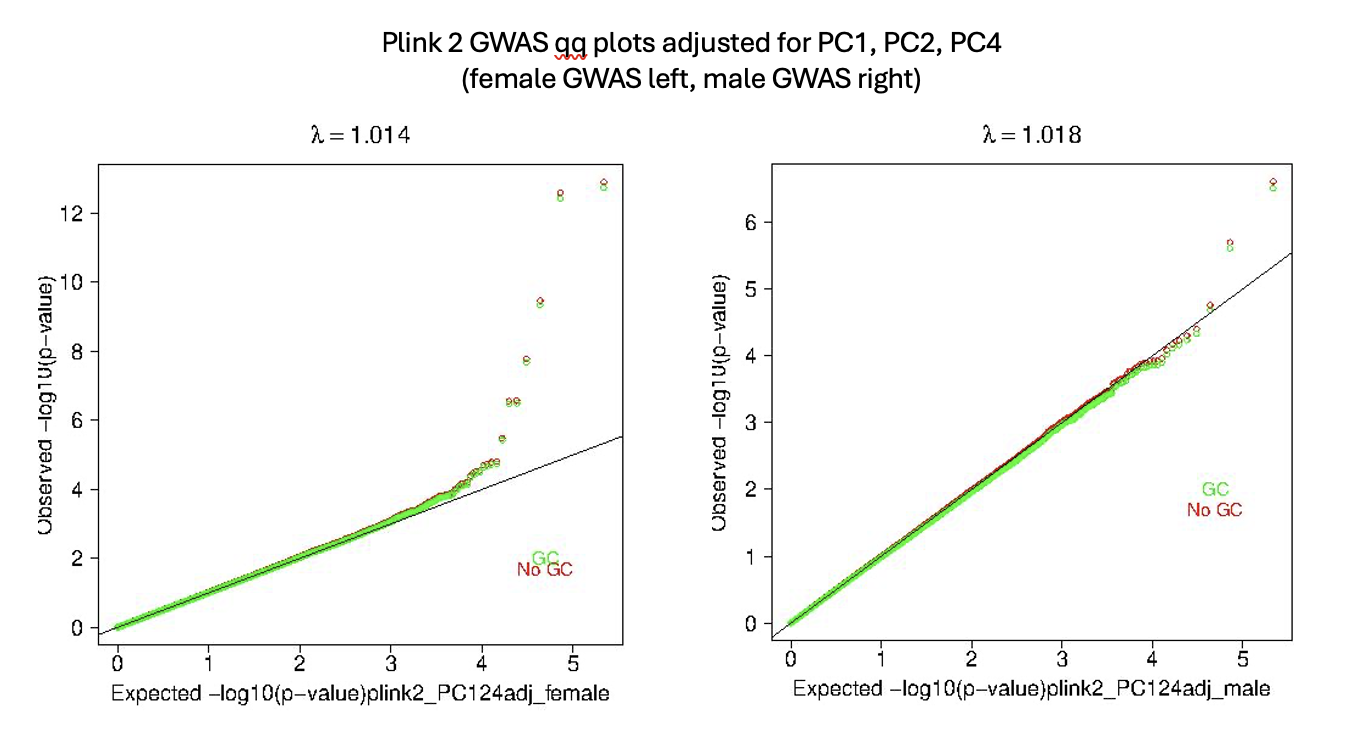

There is a little bit of inflation remaining in both subsets of data, but it seems that we were able to remove any underlying population structure. These qq plots look good, as there are upper tails towards the more significant associations. Also, it is clear that there are more highly associated variants (the tail ends) in women than in men

Next we create a manhattan plot using the provided R script from class, found below

In [36]:
%%bash
cat gwaplot.R

##R --vanilla --args filename plottitle plotfile < gwaplot.R > xx.log
##Assumes PLINK output file with CHR BP and P columns; plots all p-values (need to filter prior to running)

plotscan<-function(pvalue,chrom,physloc,plotname,filename,type="bmp",plotchar=20){
  chrom1<-ifelse(chrom%in%"X","23",ifelse(chrom%in%"Y","24",chrom))
  chrom<-as.numeric(chrom1)
  y<-data.frame(chrom,physloc,pvalue)
  y<-y[order(y$chrom,y$physloc),]
  maxlist<-NULL
  nchrom<-length(unique(chrom))
  for(i in 1:nchrom){
    maxlist<-c(maxlist,max(subset(y,chrom==i)$physloc))}
  chromlist<-data.frame(chr=1:nchrom,max=maxlist)
  chromlist$max<-chromlist$max+500000
  chromlist$cumsum<-NULL
  chromlist$cumsum<-cumsum(as.numeric(chromlist$max))
  chromlist$cumsum2[2:nchrom]<-chromlist$cumsum[1:(nchrom-1)]
  chromlist$cumsum2[1]<-0
  chromlist$addon<-chromlist$cumsum2
  chromlist$chrend<-chromlist$max+chromlist$addon
  chromlist$chrbeg<-chromlist$chrend-chromlist$max
  chromlist$midpt<-chromlist$chrbeg+(chromlist$chr

In [37]:
%%bash
Rscript --vanilla gwaplot.R q2.2_narac_gwas_male.PHENO1.glm.logistic.hybrid.ssf.tsv "plink2 male" plink2_male_manhattan
Rscript --vanilla gwaplot.R q2.2_narac_gwas_female.PHENO1.glm.logistic.hybrid.ssf.tsv "plink2 female" plink2_female_manhattan

[1] "q2.2_narac_gwas_male.PHENO1.glm.logistic.hybrid.ssf.tsv"
[2] "plink2 male"                                            
[3] "plink2_male_manhattan"                                  
null device 
          1 
[1] "q2.2_narac_gwas_female.PHENO1.glm.logistic.hybrid.ssf.tsv"
[2] "plink2 female"                                            
[3] "plink2_female_manhattan"                                  
null device 
          1 


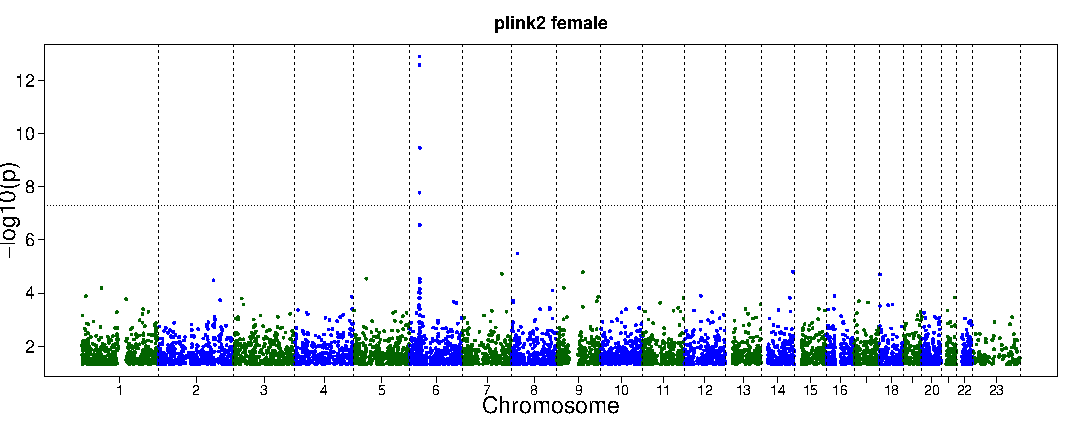

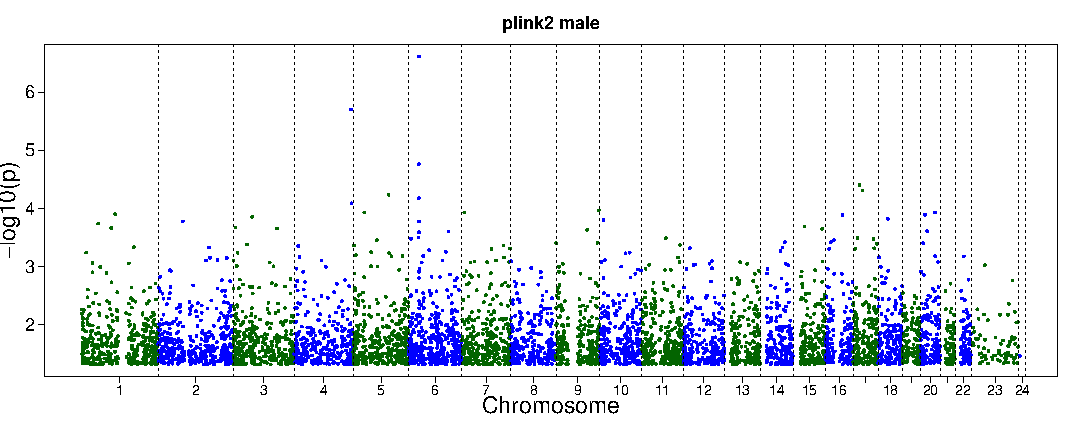

#### GWAS QA/graphs summary
Plink2.0's GWAS analysis succesfully identified a region of highly significant associations on chromosome 6 in women (and slight association in men), which we can assume to be the HLA region. This is based off of the p-value threshold of 5e-8. There were 4 statistically significant SNP's in women, and none in men. However, the GWAS failed to identify any other regions that are highly associated in both men and women. The qq plots showed that including PC's 1, 2, and 4 succesfully accounted for underlying population structure. Below are the ten most highly associated SNP's in men and women.

Variant rs405875 is unique to being highly associated in women, and is the strongest assoication. It has a negative effect, meaning having the *effect* allele is highly associated with *not* having RA. The next most significant variant in women is rs532098, and this is the most significant variant in men (but not lower than 5e-8 for men). Note that in women, the effect estimate is positive but in men the effect estimate is negative. While this may seem contradictory at first, it is explained by a switching of the effect versus other allele in men versus women. This is because the effect allele is typically reported as whichever allele is rarer, and splitting the sample into men and women may have altered the frequency of the allele in each case. Overall, the variants that are highly associated with RA in men and women are largely shared.

In [38]:
%%bash
echo "Most significant SNP's in male subjects"
sort -gk 8 q2.2_narac_gwas_male.PHENO1.glm.logistic.hybrid.ssf.tsv | head
echo && echo && echo "Most significant SNP's in female subjects"
sort -gk 8 q2.2_narac_gwas_female.PHENO1.glm.logistic.hybrid.ssf.tsv | head

Most significant SNP's in male subjects
chromosome	base_pair_location	effect_allele	other_allele	beta	standard_error	effect_allele_frequency	p_value	rsid	n
6	32578052	G	A	-0.788747	0.152819	0.495528	2.45214e-07	rs532098	559
4	184571085	A	G	0.703156	0.147943	0.462433	2.00538e-06	rs6552695	559
6	32215188	G	A	0.662136	0.154185	0.481216	1.75151e-05	rs405875	559
17	20910834	G	A	0.605746	0.147451	0.449016	3.98909e-05	rs4985959	559
17	30899334	A	G	-0.584272	0.144068	0.5	5.00212e-05	rs225218	557
5	115348816	A	G	0.914471	0.227713	0.120968	5.92218e-05	rs17138656	558
6	32199352	G	A	0.582102	0.146038	0.447227	6.72043e-05	rs9267873	559
4	186430436	G	A	1.93687	0.492053	0.029517	8.27451e-05	rs10446841	559
9	138893874	A	G	0.585007	0.15124	0.488288	0.000109694	rs7869795	555


Most significant SNP's in female subjects
chromosome	base_pair_location	effect_allele	other_allele	beta	standard_error	effect_allele_frequency	p_value	rsid	n
6	32215188	A	G	-0.706089	0.0952347	0.492102	1.22362e-13	rs405875	1456
6	

### 2B Meta-analysis combining male and female subsets
Perform a genome-wide meta-analysis that combines the male-only and female-only results with a test for heterogeneity. Present a written summary of your findings, including appropriate plots and tables, and be sure to address the questions: do males and females show association in the same regions? Do the significantly associated SNPs appear to have similar effects in males as in females? Discuss the limitations of the data and the methods you used.

A meta analysis allows us to incorporate GWAS information from multiple studies, weigh each study's results, and produce a combined GWAS analysis with (hopefully) additional power. In our case, we weigh the effect size estimates of each variant with it's corresponding inverse standard error. Typically we would need to be very cautious about making sure each study's effect estimates and standard errors were measured the same, i.e. have the same units. However, in our case we are simply splitting our original GWAS into two pseudo-studies, one for women and one for men, and then combining their results. Our null hypothesis is the same- that each variant does not have an association with RA case status across both men and women. Our alternative hypothesis is that the combined effect across all studies of each variant *is* associated with RA case status.

To perform a meta analysis, we will use the METAL software, which requires us to create a text file containing the METAL commands to run and which columns to pull from for each GWAS results file. Here is the metal.txt file:
- `TRACKPOSITIONS`, `CHROMOSOMELABEL`, and `POSITIONLABEL` are simply to retain these columns in the output for plotting GWAS
- `SCHEME STDERR` is for our weighing approach mentioned above (effect size x inverse standard error)

In [39]:
%%bash
cat q2b_metal.txt

SCHEME   STDERR
GENOMICCONTROL ON
AVERAGEFREQ ON
MINMAXFREQ ON
MARKER  rsid
ALLELE   effect_allele other_allele
CHROMOSOMELABEL chromosome
POSITIONLABEL base_pair_location
TRACKPOSITIONS ON
SEPARATOR TAB

##These options I reset for each study
##I need to process the file each time I change them, so that all 
##of the study-specific effects are read in
FREQ     effect_allele_frequency
EFFECT   beta
STDERR   standard_error
PVAL     p_value
PROCESS	 q2.2_narac_gwas_female.PHENO1.glm.logistic.hybrid.ssf.tsv

FREQ     effect_allele_frequency
EFFECT   beta
STDERR   standard_error
PVAL     p_value
PROCESS	 q2.2_narac_gwas_male.PHENO1.glm.logistic.hybrid.ssf.tsv


OUTFILE narac_meta .tbl
ANALYZE HETEROGENEITY


In [40]:
%%bash
metal q2b_metal.txt > q2b_metal.log

#### 2B Meta Analysis Summary

Below is a qq plot and GWAS manhattan plot to assess the results of the meta analysis. Note I manually renamed the p-value columns in metal output as the Rscripts were giving me errors (for qqplot and gwas).

The qqplot looks promising. Firstly, there are more significant associations in comparison to the subset male/female datasets, shown through the longer rising tail. Additionally, the observed p-values are more significant as well. There is still no apparent underlying population structure that has not been accounted for, and the genomic inflation value (lambda) is very close to 1. The manhattan plot looks very similar to the subset data manhattan plots as well. Overall, I would say these meta-analyses results are better than the separate male/female dataset GWASs alone.

The expected HLA region is observed in the chromosome 6 associations, and we fail to see any other regions of the genome that exhibits strong association for RA. When inspecting the top 10 most significant SNP's (lowest p-values), we see that they all reside on chromsome 6. Five to six of these SNP's are statistically significant, being below the threshold of 5e-8. Another good sign is that the directions for these SNP's align with each other. In other words, the effect allele influences RA the same way in both men and women. Lastly, we observe that the Q statistic and associated p-values for heterogeneity of effects are not significant, meaning the effect alleles contributing to the meta analysis are not heterogeneous, i.e. not in conflict with each other.

One of the limitations of my approach is that the plink2 logistic model for generating GWAS results does not account for random effects, only fixed effects through the principle component covariates. The GMMAT software does account for random effects by using a covariance matrix of individual genetic relatedness generated by plink.

In [42]:
%%bash
# Manually had to change P-value column name in narac_meta1.tbl to pvalue
Rscript --vanilla qqplot_meta.R narac_meta1.tbl narac_meta

[1] "narac_meta1.tbl" "narac_meta"     
null device 
          1 


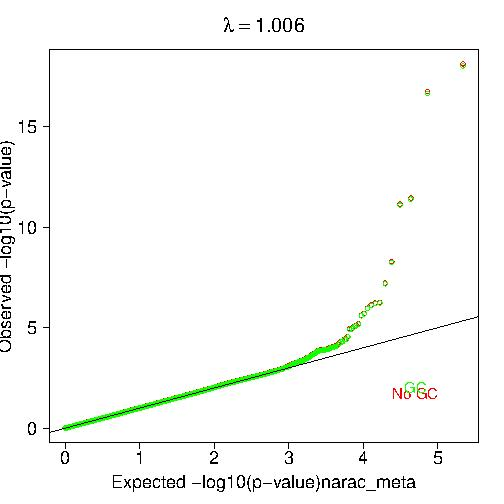

In [43]:
%%bash
Rscript --vanilla gwaplot_meta.R narac_meta1.tbl "NARAC metaanalysis" narac_meta_analysis

[1] "narac_meta1.tbl"     "NARAC metaanalysis"  "narac_meta_analysis"
null device 
          1 


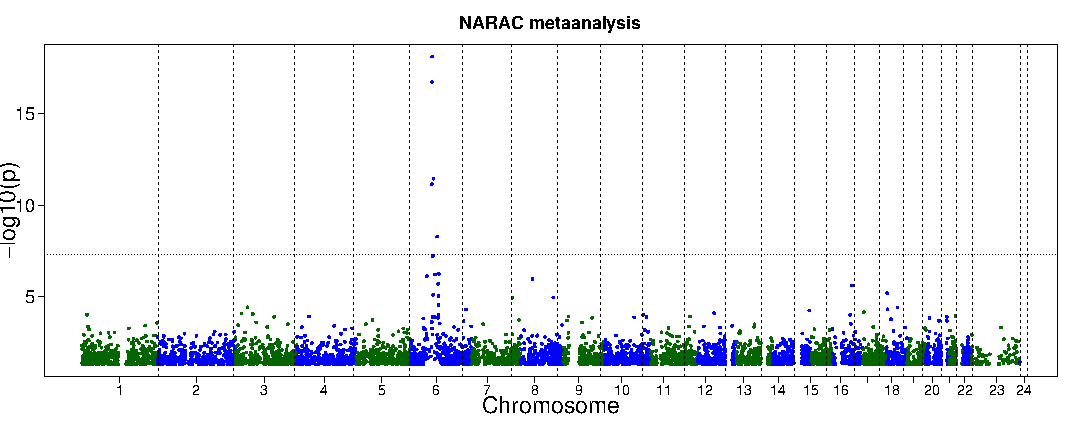

In [44]:
%%bash
echo 'Results of meta analysis: top 10 most significant SNPs' && echo
sort -gk 12 narac_meta1.tbl | head

Results of meta analysis: top 10 most significant SNPs

Chromosome	Position	MarkerName	Allele1	Allele2	Freq1	FreqSE	MinFreq	MaxFreq	Effect	StdErr	pvalue	Direction	HetISq	HetChiSq	HetDf	HetPVal
6	32578052	rs532098	a	g	0.4984	0.0037	0.4962	0.5045	0.7060	0.0796	7.64e-19	++	0.0	0.393	1	0.5309
6	32215188	rs405875	a	g	0.4994	0.0119	0.4921	0.5188	-0.6940	0.0816	1.872e-17	--	0.0	0.058	1	0.8099
6	32682724	rs3873444	a	g	0.0797	0.0051	0.0762	0.0871	-1.2159	0.1749	3.557e-12	--	0.0	0.779	1	0.3773
6	32199352	rs9267873	a	g	0.5376	0.0101	0.5309	0.5528	-0.5575	0.0813	7.123e-12	--	0.0	0.040	1	0.841
6	32961361	rs9500927	a	g	0.1264	0.0020	0.1232	0.1277	-0.7405	0.1267	5.139e-09	--	0.0	0.098	1	0.7537
6	32681161	rs2858332	a	c	0.5432	0.0095	0.5286	0.5495	0.4182	0.0772	6.084e-08	++	6.7	1.072	1	0.3004
6	33846143	rs4713711	a	g	0.7157	0.0057	0.7070	0.7194	0.4345	0.0868	5.587e-07	++	0.0	0.343	1	0.558
6	32795032	rs10484565	a	g	0.1007	0.0034	0.0948	0.1026	0.6400	0.1282	5.985e-07	++	0.0	0.522	1	0.4699
6	31510924	rs28

## Question 3
Use LD score regression and the Okada et al summary statistics to 1) estimate the
heritability of RA, and 2) compare the heritability in the Asian and European populations.
Describe your methods (including all assumptions you’ve made) and present and explain
your results.

LD score regression tests for the heritability of a trait in a population, i.e. estimating the proportion of phenotypic variance that can be explained by common genetic variants. We perform LDSC by combining the outcome of our meta-analysis GWAS with information about linkage disequilibrium scores for all variants, and perform a regression. Because our outcome is dichotomous, we should also incorporate population and sample prevalance which allows us to transform our heritability and interpret it on the liability-scale. According to the article, we can assume a population prevalance is 0.5%, or 0.005. The sample prevalance for the european study is 14361/(14361+43923) = 0.246. The sample prevalance for the asian study is 4873/(4873+17642) = 0.216. The hypotheses we are testing are:
- Null hypothesis: there is no SNP-based heritability for RA in the respective populations
- Alternative hypothesis: there is SNP-based heritability for RA in the respective populations

We will use the LDSC python 2 software on the provided summary statistic files. Unfortunately the software runs on python 2 and this notebook is using python 3, so I will write out the code and run it separately on terminal.

In [45]:
%%bash
export RA_DATA='/projectnb/bs859/data/RheumatoidArthritis/final_project'
ls $RA_DATA
head $RA_DATA/RA_GWASmeta_European_v2.txt

EAS.1000G.AF.
EUR.1000G.AF.
RA_GWASmeta_Asian_v2.txt.gz
RA_GWASmeta_European_v2.txt
RA_GWASmeta_TransEthnic_v2.txt.gz
narac.cov
narac_hg19.bed
narac_hg19.bim
narac_hg19.fam
SNPID	Chr	Position(hg19)	A1	A2	OR	OR_95%CIlow	OR_95%CIup	P-val
chr1:751343	1	751343	A	T	0.85	0.75	0.96	0.01
chr1:751756	1	751756	T	C	1.17	1.04	1.33	0.01
rs3094315	1	752566	A	G	1.14	1.03	1.26	0.0093
rs3131972	1	752721	A	G	0.88	0.79	0.97	0.009
rs3131971	1	752894	T	C	0.87	0.78	0.97	0.01
chr1:753405	1	753405	A	C	1.17	1.04	1.32	0.01
chr1:753425	1	753425	T	C	0.87	0.78	0.97	0.0097
rs2073814	1	753474	G	C	1.14	1.03	1.27	0.009
rs2073813	1	753541	A	G	0.85	0.75	0.96	0.0095


LDSC requires a list of SNP's, and we will use the list provided from a previous homework assignment, but I'm not sure about this step. Also, before we actually perform LDSC we need to reformat the data using`munge_sumstats`. In the munge-stats command, we specify the number of cases and controls in each study manually, and changed the `--signed-sumstats` to OR,1 to reflect what is reported in the summary statistics (odds ratio centered around 1 instead of beta).

Here are the log files for munge sumstats for EUR and EAS GWAS studies.

In [46]:
%%bash
cat q3_RA_EURO.log
cat q3_RA_EAS.log

*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./munge_sumstats.py \
--signed-sumstats OR,1 \
--out q3_RA_EURO \
--merge-alleles /projectnb/bs859/data/ldscore_files/w_hm3.snplist \
--N-con 43923.0 \
--N-cas 14361.0 \
--a1 A1 \
--a2 A2 \
--snp SNIPD \
--sumstats /projectnb/bs859/data/RheumatoidArthritis/final_project/RA_GWASmeta_European_v2.txt 

Interpreting column names as follows:
A1:	Allele 1, interpreted as ref allele for signed sumstat.
OR:	Directional summary statistic as specified by --signed-sumstats.
SNPID:	Variant ID (e.g., rs number)
A2:	Allele 2, interpreted as non-ref allele for signed sumstat.
P-val:	p-Value

Reading list of SNPs for allele merge from /projectnb/bs859/data

The next step is to run LD score regression analysis, using the UKBB EUR and EAS refernce LD panels and weights for regression.

In [47]:
%%bash
echo 'EUR h2' 
cat q3.1_RA_EURO_h2.log 

echo && echo 'EAS h2'
cat q3.1_RA_EAS_h2.log 

EUR h2
*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--h2 q3_RA_EURO.sumstats.gz \
--out q3.1_RA_EURO_h2 \
--pop-prev 0.005 \
--samp-prev 0.246 \
--w-ld /projectnb/bs859/data/ldscore_files/UKBB.ALL.ldscore/UKBB.EUR.rsid \
--ref-ld /projectnb/bs859/data/ldscore_files/UKBB.ALL.ldscore/UKBB.EUR.rsid 

Beginning analysis at Sat May  4 17:48:30 2024
Reading summary statistics from q3_RA_EURO.sumstats.gz ...
Read summary statistics for 1182454 SNPs.
Reading reference panel LD Score from /projectnb/bs859/data/ldscore_files/UKBB.ALL.ldscore/UKBB.EUR.rsid ...
Read reference panel LD Scores for 1094844 SNPs.
Removing partitioned LD Scores with zero variance.
Reading regression weight

For both the EUR and EAS GWAS studies, we see that there is an amount of variation in RA case status explained by additive genetic effects (variants found in the hapmap phase 3 snp list). For the European population, roughly 9% of the variation in RA is explained after converting the h2 to a liability scale, whereas in the East Asian population 12% of the variation is explained after converting to a liability scale. This is again based on the assumed prevalance of 0.5% cited in the article, however I'm unsure of the origins of this statistic and it is very possible that the prevalance of RA greatly varies depending on the region.

There are some study specific differences (outside of population differences) that may attribute to differences in the heritability estimates. Namely, the number of SNP's being used in each population study varies. In the EURO population, the LDSC analysis used 1,075,968 SNPs, whereas the in the East Asian population 933,518 SNP's were used. The difference of 142,000 SNPs may be responsible for the heritability differences observed in European vs East Asian populations.

There are many assumptions being made about this LDSC. One of the major assumptions of performing LD score regression is that the effects of individual genetic variants are additive and can be quantified by a single effect size. However, RA is not fully understood and may display either additive or non-additive patterns. In conjunction with this is that variation from dominant genetic effects is assumed to be 0. Another important assumption is that the effect estimates for each variant follow a normal distribution. These assumptions combined allow us to incorporate the genetic variation in cases and controls of individuals to estimate the heritability of Rheumatoid Arthritus on a liability-scale.

---

## Supplementary work
This section contains some troubleshooting/'trying things out' code.

I would have liked to use GMMAT for my GWAS analyses because it utilizes mixed effect models, combining both fixed effects like population structure and random effects that may arise via patterns of genetic relatedness between individuals. I end up 

### SUPPLEMENTARY 2A Sex GWAS with Plink1.9 and GMMAT
Perform two genome-wide association analyses for rheumatoid arthritis: one using only female
subjects, and one using only male subjects. Explain how you chose covariates, and how you
accounted for population structure (or, if you chose not to account for population structure,
justify your decision). Present a written summary of your results with appropriate plots and
tables that describe your findings.

To actually run the GWAS analysis, both plink and GMMAT will be used and have their results compared.

First we will run the **plink 1.9 GWAS**. While running the GWAS, we hide covariate rows so we can focus on SNP associations, and also report effect estimates as regression coefficients (beta) instead of odds ratios. 

In [48]:
%%bash
# male gwas
plink --bfile q2.1_narac_cleaned_males \
    --logistic beta hide-covar \
    --covar q1.10_narac_PCs.txt \
    --covar-name PC1,PC2,PC4 \
    --out q2s_narac_gwas_male
    
# female gwas    
plink --bfile q2.1_narac_cleaned_females \
    --logistic beta hide-covar \
    --covar q1.10_narac_PCs.txt \
    --covar-name PC1,PC2,PC4 \
    --out q2s_narac_gwas_females

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q2s_narac_gwas_male.log.
Options in effect:
  --bfile q2.1_narac_cleaned_males
  --covar q1.10_narac_PCs.txt
  --covar-name PC1,PC2,PC4
  --logistic beta hide-covar
  --out q2s_narac_gwas_male

191515 MB RAM detected; reserving 95757 MB for main workspace.
106358 variants loaded from .bim file.
559 people (559 males, 0 females) loaded from .fam.
559 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
--covar: 3 out of 10 covariates loaded.
Before main variant filters, 559 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996741.
106358 variants and 559 

treat these as missing.


Total genotyping rate is 0.996399.
106358 variants and 1456 people pass filters and QC.
Among remaining phenotypes, 626 are cases and 830 are controls.
Writing logistic model association results to
q2s_narac_gwas_females.assoc.logistic ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.


Next we will run the **GMMAT GWAS** using an R script on both male and female subset data. Before doing this, GMMAT requires a relationship matrix, which contains pairwise covariance values for all individuals. We will use plink to generate this matrix. Using GMMAT allows us to incorporate mixed effect models, whereas plink does not. Mixes effect models in the context of GWAS will allow us to control for fixed effects like population structure (represented through the principle components) and random effects like individual relatedness (represented through the covariance matrix).

In [49]:
%%bash
# generate covariance matrix for GMMAT using plink, for both men and women
plink --bfile q2.1_narac_cleaned_males \
    --make-rel square \
    --out q2s.3_relmat_male
    
plink --bfile q2.1_narac_cleaned_females \
    --make-rel square \
    --out q2s.3_relmat_female

PLINK v1.90b6.27 64-bit (10 Dec 2022)          www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to q2s.3_relmat_male.log.
Options in effect:
  --bfile q2.1_narac_cleaned_males
  --make-rel square
  --out q2s.3_relmat_male

191515 MB RAM detected; reserving 95757 MB for main workspace.
106358 variants loaded from .bim file.
559 people (559 males, 0 females) loaded from .fam.
559 phenotype values loaded from .fam.
Using up to 31 threads (change this with --threads).
Before main variant filters, 559 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996741.
106358 variants and 559 people pass filters and QC.
Among remaining phenotypes, 224 are cases and 335 are controls.
Excluding 1806 varian

treat these as missing.


Total genotyping rate is 0.996399.
106358 variants and 1456 people pass filters and QC.
Among remaining phenotypes, 626 are cases and 830 are controls.
Excluding 1806 variants on non-autosomes from relationship matrix calc.
Relationship matrix calculation complete.
Relationship matrix written to q2s.3_relmat_female.rel , and IDs written to
q2s.3_relmat_female.rel.id .


Now we have a way to control for random effects (covariance matrix) and fixed effects (principle components). Lastly, we want to run wald tests (opposed to score tests) in GMMAT to get reported beta effect estimates which can be used later on in the meta-analysis when combining the male and female datasets back into one. Additionally, the GLMM wald test prioritizes analyzing random effects whereas the score test prioritizes fixed effects. The wald tests require a list of SNP's to test for, so we will generate a file of a list of all SNPs to read into the R script.

In [53]:
%%bash
# R script used for GMMAT GLMM
cat GMMAT_male.R

library(GMMAT)
pheno<-read.table("q2.1_narac_cleaned_males.fam",header=F)
colnames(pheno)<-c("FID","IID","fa","mo","sex","case")
pcs<-read.table("q1.10_narac_PCs.txt",header=T,as.is=T)

# merge the PC data with the fam file (pheno) data.

pheno1<-merge(pheno,pcs,by=c("FID","IID"),all.x=TRUE)

##Read in the GRM (genetic relationship matrix)
grm<-as.matrix(read.table("q2s.3_relmat_male.rel",header=F))

# Read in the grm id file:
grm.ids<-read.table("q2s.3_relmat_male.rel.id",header=F)
#apply the IDs to the two dimensions of the grm.  This is how
#gmmat will know which row and column belongs to each ID

dimnames(grm)[[1]]<-dimnames(grm)[[2]]<-grm.ids[,2]

## These two commands create the Null models (no SNPs) for the score tests.  We 
## are doing two different Null models -- model1.0 has no covariates.
## model2.0 has covariates PC1 and PC2

#model1.0<-glmmkin(case-1~1,data=pheno1,id="IID",kins=grm,family=binomial("logit")) #no covariate
model2.0<-glmmkin(case-1~PC1+PC2+PC4,data=pheno1,i

In [55]:
%%bash
## Run GMMAT analyses
Rscript --vanilla GMMAT_male.R
Rscript --vanilla GMMAT_female.R

To make the output files match plink's format, we can simply rename some columns

In [ ]:
%%bash
# Rename output columns to match plink's format
awk 'NR==1{$4="BP";$11="P"};{print $0}' q2.3.glmm.score.female > q2.3.glmm_plinkformat.score.female
awk 'NR==1{$4="BP";$11="P"};{print $0}' q2.3.glmm.score.male > q2.3.glmm_plinkformat.score.male

Now we run the Rscript for all four datasets.

In [ ]:
%%bash 
#plink
Rscript --vanilla qqplot_supplementary.R q2s_narac_gwas_females.assoc.logistic PC124adj_female ADD
Rscript --vanilla qqplot_supplementary.R q2s_narac_gwas_male.assoc.logistic PC124adj_male ADD
#gmmat
Rscript --vanilla qqplot_supplementary.R q2s.glmm_plinkformat.score.male "glmm_male_pc124"
Rscript --vanilla qqplot_supplementary.R q2s.glmm_plinkformat.score.female "glmm_female_pc124"

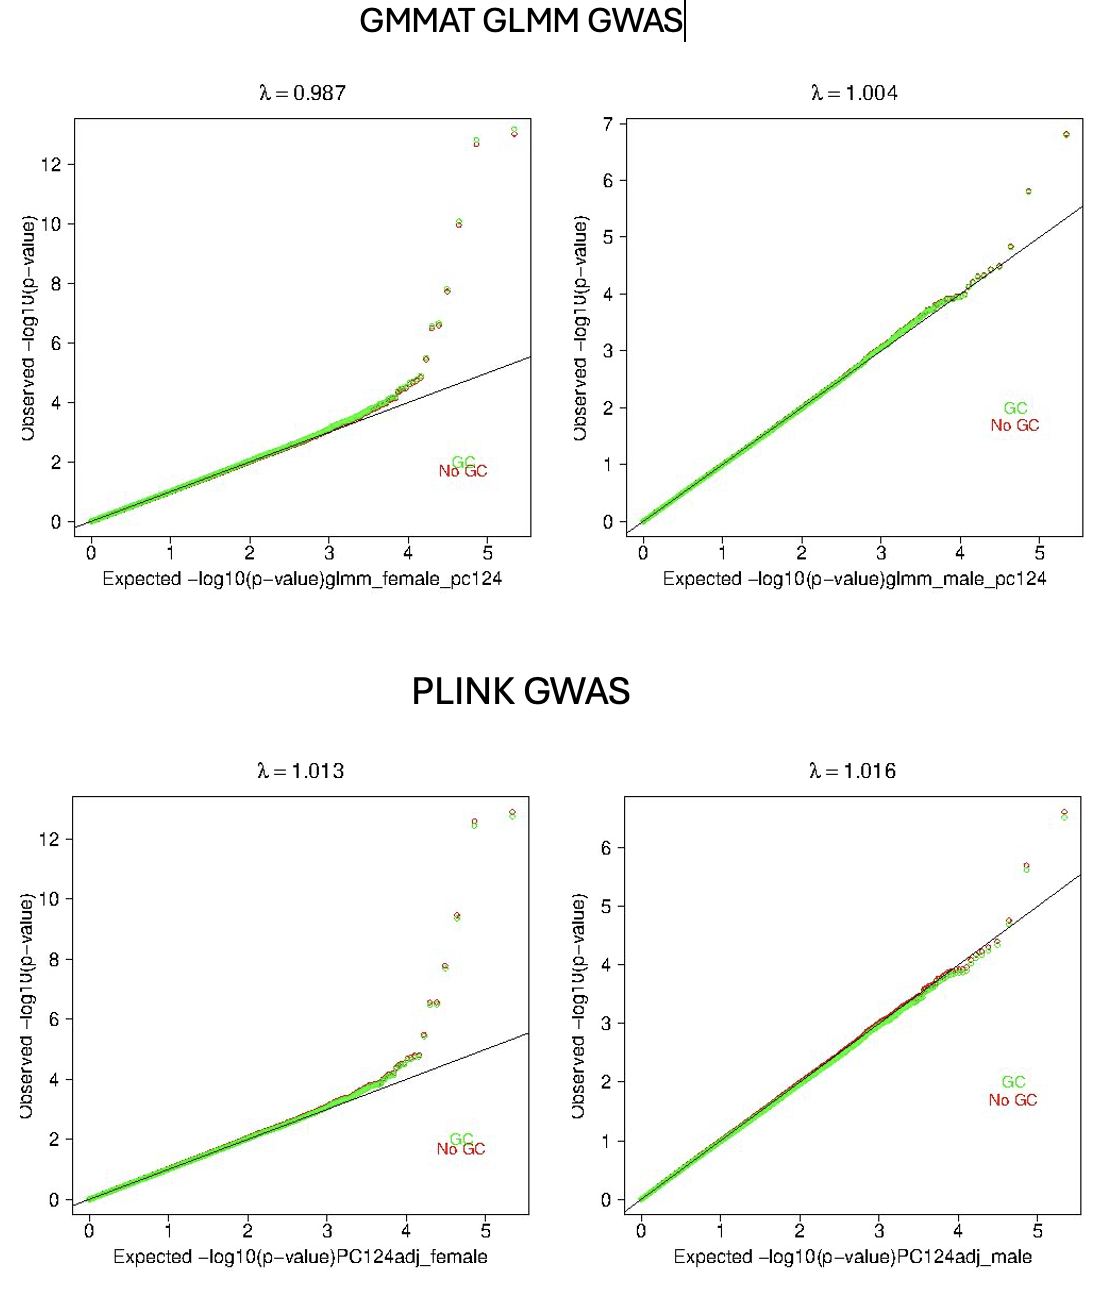

These are the QQ plots generated for each dataset. Across the GWAS methods, the results are very similar for males and females. Population structure appears to be accounted for well across all datasets, and we see a number of points highly associated through the tail flying upwards in each plot. The lambda values (which measures genomic inflation) is low for both, i.e. they are both close to 1.0, but the GMMAT results are slightly lower closer for the male population and are the same for the female population.

As a result, moving forward we will use the GMMAT GWAS results.

Lets produce a manhattan plot for the GMMAT GWAS using the provided R script from class. Here is the R script. 

In [ ]:
%%bash
Rscript --vanilla gwaplot_old.R q2.3.glmm_plinkformat.score.male "GLMM male" GLMM_male_manhattan
Rscript --vanilla gwaplot_old.R q2.3.glmm_plinkformat.score.female "GLMM female" GLMM_female_manhattan

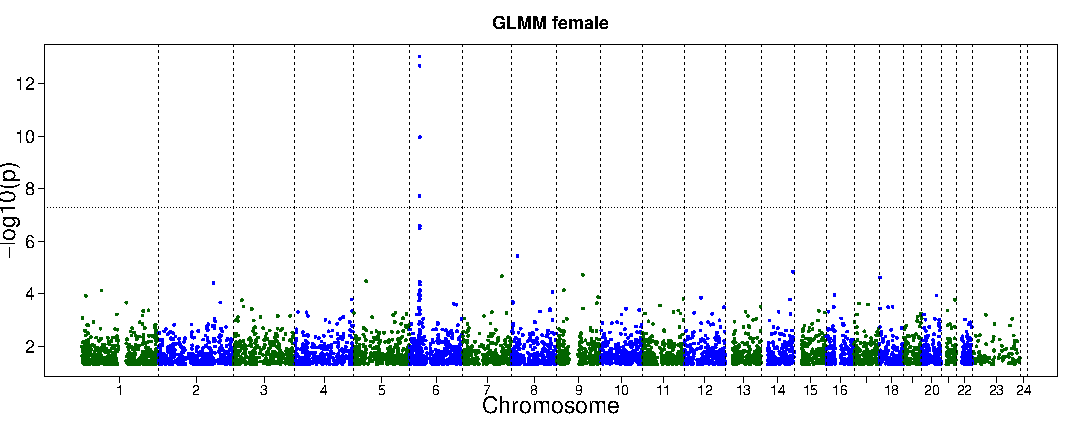

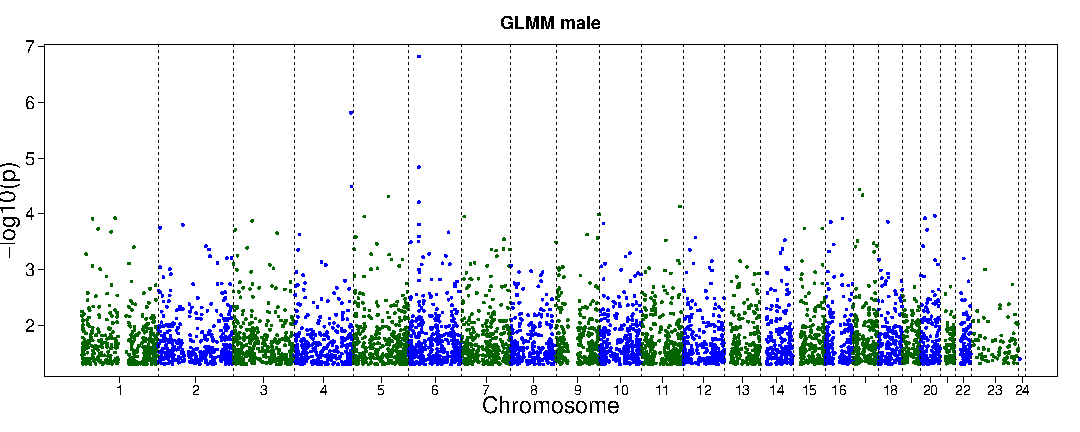

#### 2A GWAS Summary
Comparing the GMMAT and plink GWAS results via qq plots showed that both yielded very similar results, with GMMAT having a slightly lower genomic inflation value. The qq plots additionally showed that including PC's 1, 2, and 4 succesfully accounted for underlying population structure and the covariance matrix accounted for underlying genetic relatedness. The manhattan plot produced expected results. The known HLA region on chromosome 6 is clearly highly associated with RA particularly in women. There are strong associations in men as well at this site, but not as strong as in women. Additionally, it appears that there are no other strongly associated variants in men or women for RA. Below are the ten most highly associated SNP's in men and women, results coming from the GMMAT GWAS results